# AirBnB Listings in Los Angeles, CA
##### Data source: http://insideairbnb.com/get-the-data.html
##### Date compiled: May 8, 2020
## 1 - Data Cleaning

### Dependencies

In [2]:
from datetime import datetime
from urllib.request import urlopen
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

%matplotlib inline

In [3]:
# Settings
pd.options.display.max_columns = 200
pd.options.display.max_rows = 50000
sns.set()
px.set_mapbox_access_token('pk.eyJ1IjoidHJpLWJ1aSIsImEiOiJja2I1dHZuNnIwZmszMnNtcG9neWJtZXJkIn0.KD3qCv0H89Lv9mWDFyEqeA')

### Data

In [4]:
reviews = pd.read_csv('data/reviews.csv')
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1304141 entries, 0 to 1304140
Data columns (total 6 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   listing_id     1304141 non-null  int64 
 1   id             1304141 non-null  int64 
 2   date           1304141 non-null  object
 3   reviewer_id    1304141 non-null  int64 
 4   reviewer_name  1304139 non-null  object
 5   comments       1303081 non-null  object
dtypes: int64(3), object(3)
memory usage: 59.7+ MB


In [5]:
listings = pd.read_pickle('data/listings_prepped.pkl')
listings.head(2)

id  host_is_superhost neighbourhood_cleansed zipcode  latitude  longitude  \
0  109                0.0            Culver City   90230  33.98209 -118.38494   
1  344                0.0                Burbank   91505  34.16562 -118.33458   

  property_type        room_type  accommodates  bathrooms  bedrooms  beds  \
0   Condominium  Entire home/apt             6        2.0       2.0   3.0   
1         House  Entire home/apt             6        1.0       3.0   3.0   

   bed_type  price  security_deposit  cleaning_fee  guests_included  \
0  Real Bed  122.0             500.0         240.0                3   
1  Real Bed  168.0               0.0         100.0                6   

   extra_people  minimum_nights  maximum_nights  availability_30  \
0          25.0              30             730                0   
1           0.0               2              14                0   

   availability_60  availability_90  availability_365  number_of_reviews  \
0                0                0                38                  2   
1                1                6                97                  8   

   number_of_reviews_ltm first_review last_review  review_scores_rating  \
0                      0   2011-08-15  2016-05-15                  80.0   
1                      2   2016-06-14  2019-10-19                  97.0   

   review_scores_accuracy  review_scores_cleanliness  review_scores_checkin  \
0                    10.0                       10.0                    6.0   
1                    10.0                       10.0                   10.0   

   review_scores_communication  review_scores_location  review_scores_value  \
0                          8.0                    10.0                  8.0   
1                         10.0                    10.0                 10.0   

   instant_bookable          cancellation_policy  \
0                 0  strict_14_with_grace_period   
1                 1                     flexible   

   require_guest_profile_picture  require_guest_phone_verification  \
0                              1                                 0   
1                              0                                 0   

   reviews_per_month  
0               0.02  
1               0.17

In [6]:
listings.shape

(37048, 40)

### Missing data

In [7]:
missing = pd.DataFrame(listings.isnull().sum(), columns=['num_missing'])
missing['pct_missing'] = np.round(listings.isnull().mean(), 2)
missing[missing.num_missing > 0]

num_missing  pct_missing
host_is_superhost                      5         0.00
zipcode                              328         0.01
bathrooms                             35         0.00
bedrooms                             106         0.00
beds                                 381         0.01
bed_type                              10         0.00
security_deposit                    8933         0.24
cleaning_fee                        4968         0.13
first_review                        7635         0.21
last_review                         7635         0.21
review_scores_rating                8086         0.22
review_scores_accuracy              8134         0.22
review_scores_cleanliness           8133         0.22
review_scores_checkin               8146         0.22
review_scores_communication         8135         0.22
review_scores_location              8150         0.22
review_scores_value                 8154         0.22
reviews_per_month                   7635         0.21

***
##### Missing values:
- `host_is_superhost` - these 5 listings are likely by hosts who do not have a profile, these will be dropped since there are only 5
- `zipcode` - these can be filled using the `latitude` and `longitude` of nearby properties
- `bathroom`, `bedroom`, `beds`, `bed_type` - all missing an insignificant amount of values, these can be filled based on the most similar listings
- `security_deposit`, `cleaning_fee` - since these were not filled out for the listing, we are going to make the assumption that there is no fee so these will be filled with 0
- `first_review`, `last_review`, `reviews_per_month` - the data here is missing because these listings have 0 `number_of_reviews` so there is no data, `reviews_per_month` will be filled with 0 and the other 2 will be filled with the last date of the dataset (arbitrary choice)
- `review_scores_rating`, `review_scores_accuracy`, `review_cleanliness`, `review_scores_checkin`, `review_scores_communication`, `review_scores_location`, `review_scores_value` - these are likely missing for the same reason as the previous 3 (listings with no ratings), these will be left as null for now
***

In [8]:
# Drop rows missing `host_is_superhost`
listings.dropna(subset=['host_is_superhost'], inplace=True)
listings.shape

(37043, 40)

In [9]:
listings.shape

(37043, 40)

In [10]:
# Fill `security_deposit`, `cleaning_fee`, and `reviews_per_month` with 0
for col in ['security_deposit', 'cleaning_fee', 'reviews_per_month']:
    listings[col].fillna(0, inplace=True)
listings[['security_deposit', 'cleaning_fee', 'reviews_per_month']].isnull().mean()

security_deposit     0.0
cleaning_fee         0.0
reviews_per_month    0.0
dtype: float64

In [11]:
# Fill `first_review` and `last_review` with May 8, 2020
for col in ['first_review', 'last_review']:
    listings[col].fillna(datetime(2020, 5, 8), inplace=True)
listings[['first_review', 'last_review']].isnull().mean()

first_review    0.0
last_review     0.0
dtype: float64

### Zip code

In [12]:
listings.zipcode.unique()

array(['90230', '91505', '90046', '90405', '90706', '90066', '91367',
       '90039', '90291', '90802', '90277', '90019', '90247', '90068',
       '90036', '90501', '91607', '90026', '91208', '90042', '90065',
       '90232', '90025', '90004', '90027', '90012', '90265', '90401',
       '90505', '90034', '91604', '90038', '91405', '90262', '90029',
       '91344', '91206', '90212', '90211', '90006', '90403', '90069',
       '90016', '90035', '90064', '91316', '90715', '90056', '91343',
       '91042', '90045', '91364', '90402', '90010', '90745', '90814',
       '91601', '91001', '91302', '90290', '91352', '91606', '90266',
       '90275', '90803', '90292', '90018', '90404', '90712', '90020',
       '90732', '91001-2243', '91205', '90805', '91301', '91024', '90210',
       '90028', '90048', '91104', '91390', '91202', '90272', '90254',
       '90807', '90220', '91506', '91406', '90008', '90061', '90043',
       '90245', '90302', '91403', '90005', '91724', '91107', '91748',
       '91030',

***
##### A lot of these zip codes are formatted differently, but for the most part have 5 digits. Before dealing with the missing values, we will be standardizing these values to the 5-digit format to simplify it.
- Some are using the 9-digit format
- Some contain "CA" before it
- 1 contains an entire address
- 1 contains a note to the guests
- 10019, 10001, 9002, 0000 - not LA zip codes, hosts likely entered their house number in the zip code field
***

In [13]:
# Replace the wrong zip codes with null
wrong_zip_idx = listings[listings.zipcode.isin(['10019', '10001', '9002', '0000'])].index
for i in wrong_zip_idx:
    listings.loc[i, 'zipcode'] = np.NaN
listings.loc[wrong_zip_idx]

id  host_is_superhost neighbourhood_cleansed zipcode  latitude  \
13008  20183694                0.0             South Park     NaN  33.99191   
22598  31195610                0.0               Rosemead     NaN  34.04052   
31711  40180838                0.0        Adams-Normandie     NaN  34.02980   
34144  41792639                0.0              Echo Park     NaN  34.06984   

       longitude property_type        room_type  accommodates  bathrooms  \
13008 -118.27751   Condominium  Entire home/apt             5        1.0   
22598 -118.08261         Villa     Private room             2        1.0   
31711 -118.30196   Condominium  Entire home/apt             3        1.0   
34144 -118.24833         House  Entire home/apt             4        1.0   

       bedrooms  beds  bed_type  price  security_deposit  cleaning_fee  \
13008       1.0   1.0  Real Bed  349.0               0.0           0.0   
22598       1.0   2.0  Real Bed   55.0               0.0          20.0   
31711       1.0   1.0  Real Bed  275.0            1500.0         100.0   
34144       2.0   2.0  Real Bed  150.0             200.0          85.0   

       guests_included  extra_people  minimum_nights  maximum_nights  \
13008                1           0.0               1            1125   
22598                1           0.0               5            1125   
31711                1           0.0              30            1125   
34144                1           0.0               1            1125   

       availability_30  availability_60  availability_90  availability_365  \
13008               28               58               88               363   
22598                0                0                0                 0   
31711               28               58               88               178   
34144               23               44               72               225   

       number_of_reviews  number_of_reviews_ltm first_review last_review  \
13008                  0                      0   2020-05-08  2020-05-08   
22598                 19                      6   2019-01-27  2019-06-17   
31711                  0                      0   2020-05-08  2020-05-08   
34144                  0                      0   2020-05-08  2020-05-08   

       review_scores_rating  review_scores_accuracy  \
13008                   NaN                     NaN   
22598                  96.0                    10.0   
31711                   NaN                     NaN   
34144                   NaN                     NaN   

       review_scores_cleanliness  review_scores_checkin  \
13008                        NaN                    NaN   
22598                       10.0                   10.0   
31711                        NaN                    NaN   
34144                        NaN                    NaN   

       review_scores_communication  review_scores_location  \
13008                          NaN                     NaN   
22598                         10.0                    10.0   
31711                          NaN                     NaN   
34144                          NaN                     NaN   

       review_scores_value  instant_bookable          cancellation_policy  \
13008                  NaN                 0                     flexible   
22598                 10.0                 0  strict_14_with_grace_period   
31711                  NaN                 0  strict_14_with_grace_period   
34144                  NaN                 0  strict_14_with_grace_period   

       require_guest_profile_picture  require_guest_phone_verification  \
13008                              0                                 0   
22598                              0                                 0   
31711                              0                                 0   
34144                              0                                 0   

       reviews_per_month  
13008               0.00  
22598               1.22  
31711      

In [14]:
# Replace the address value with the correct zip code
address_zip_idx = listings[listings.zipcode == '139 S Valencia Ave, Glendora. 91741'].index
listings.loc[address_zip_idx[0], 'zipcode'] = '91741'
listings.loc[address_zip_idx]

id  host_is_superhost neighbourhood_cleansed zipcode  latitude  \
20574  28917093                0.0               Glendora   91741  34.13434   

       longitude property_type     room_type  accommodates  bathrooms  \
20574 -117.87759         Villa  Private room             2        1.0   

       bedrooms  beds  bed_type  price  security_deposit  cleaning_fee  \
20574       1.0   1.0  Real Bed   26.0             200.0           8.0   

       guests_included  extra_people  minimum_nights  maximum_nights  \
20574                1           8.0               1            1125   

       availability_30  availability_60  availability_90  availability_365  \
20574                8               38               68                68   

       number_of_reviews  number_of_reviews_ltm first_review last_review  \
20574                 12                      9   2018-12-10  2020-02-02   

       review_scores_rating  review_scores_accuracy  \
20574                  97.0                    10.0   

       review_scores_cleanliness  review_scores_checkin  \
20574                       10.0                   10.0   

       review_scores_communication  review_scores_location  \
20574                         10.0                    10.0   

       review_scores_value  instant_bookable          cancellation_policy  \
20574                 10.0                 0  strict_14_with_grace_period   

       require_guest_profile_picture  require_guest_phone_verification  \
20574                              0                                 0   

       reviews_per_month  
20574                0.7

In [15]:
# Remove `CA` from zip codes
listings['zipcode'] = listings.zipcode.str.strip('CA ')

# Remove everything beyond the first 5 digits from zip codes
listings['zipcode'] = listings.zipcode.str[:5]

listings.zipcode.unique()

array(['90230', '91505', '90046', '90405', '90706', '90066', '91367',
       '90039', '90291', '90802', '90277', '90019', '90247', '90068',
       '90036', '90501', '91607', '90026', '91208', '90042', '90065',
       '90232', '90025', '90004', '90027', '90012', '90265', '90401',
       '90505', '90034', '91604', '90038', '91405', '90262', '90029',
       '91344', '91206', '90212', '90211', '90006', '90403', '90069',
       '90016', '90035', '90064', '91316', '90715', '90056', '91343',
       '91042', '90045', '91364', '90402', '90010', '90745', '90814',
       '91601', '91001', '91302', '90290', '91352', '91606', '90266',
       '90275', '90803', '90292', '90018', '90404', '90712', '90020',
       '90732', '91205', '90805', '91301', '91024', '90210', '90028',
       '90048', '91104', '91390', '91202', '90272', '90254', '90807',
       '90220', '91506', '91406', '90008', '90061', '90043', '90245',
       '90302', '91403', '90005', '91724', '91107', '91748', '91030',
       '90014', '916

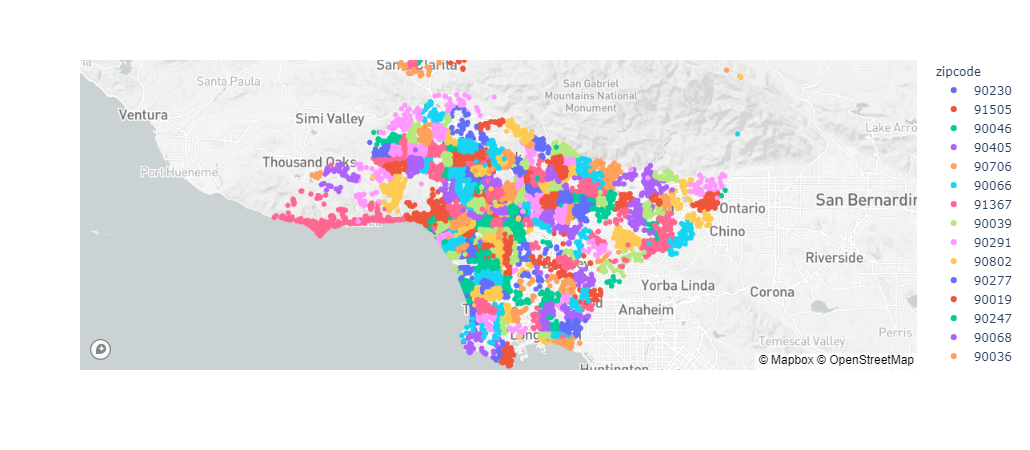

In [16]:
px.scatter_mapbox(listings[~listings.zipcode.isnull()], 'latitude', 'longitude', color='zipcode')